In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

# The anomaly injection, then running the algorithm to detect anomalous edges and communities: 

K: The number of communities (8) is determined from the cross-validation results of the MT algorithm. <br>

running algorithm: main_w_temp.py<br>

for <span style="font-family: 'Courier New', monospace;">rho_values  = [0.1]</span> <br>

and <span style="font-family: 'Courier New', monospace;"> rseeds = [300, 400, 500, 600, 700, 3000, 4000, 5000, 6000, 7000].</span><br>

Here, we load the results, stored in  "../data/output/5-fold_cv/real_data/transfermarket/injected/theta_adjacency_2008_23_len_str(**rho_value**)_str(rseed)_injected_4_81_ACD_Wdynamic.npz",<br>

Then calculate 'AUC', 'Recall', and 'AUCZ'.<br>

At the end of this notebook, we load the 'AUC', 'Recall', and 'AUCZ' resulted from other datasets to plot **FIG. ...: Anomaly Detection in the real-world datasets**.

### transfermarket-2008_2023 datasets, injecting some targeted edges  

In [2]:
import sys
sys.path.append('../')
sys.path.append('../Dyn_ACD')

import Dyn_ACD as DynACD 

import pandas as pd
import os
import networkx as nx
import numpy as np   
import importlib
import matplotlib.pyplot as plt
import sktensor as skt
from sklearn import metrics
from sklearn.metrics import f1_score
import seaborn as sns 
sns.set_theme()
sns.set_style("ticks") 
%matplotlib inline 

# import AJointCRep_AnomalyDetection as adet
# import AnomalyInjection as AI
import random
import yaml
from netgraph import Graph
from community import community_louvain

# import time_glob as gl
%matplotlib inline

# import wget

In [3]:
# compare naive classifiers with f1-measure
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.dummy import DummyClassifier
from matplotlib import pyplot
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import make_scorer, fbeta_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score 

from sklearn.dummy import DummyClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, brier_score_loss
import numpy as np

In [4]:
%matplotlib notebook

In [5]:
cmap = 'PuBuGn'

def expected_Aija(U,V,W):
    if W.ndim==1:
        M=np.einsum('ik,jk->ijk',U,V)
        M=np.einsum('ijk,k->ij',M,W)
    else:    
        M=np.einsum('ik,jq->ijkq',U,V)
        M=np.einsum('ijkq,kq->ij',M,W)
    return M

In [6]:
!pwd

/Users/hsafdari/Dropbox/Dr_Caterina_de_Bacco/anomaly_detection/Dynamic_ACD/cdebacco/notebooks_RD


In [14]:
infolder='../data/input/real_data/'
net = 'transfermarket'
dataset = 'adjacency_2008_23_len' 
dir_in = infolder
input_data = pd.read_csv(dir_in+net+'/'+dataset+'.dat', header=0, sep='\s+', comment='#')

In [15]:
infolder+dataset+'.dat'

'../data/input/real_data/adjacency_2008_23_len_Milan_Mixed.dat'

In [16]:
df = pd.DataFrame(input_data)
df.head(n=5)

,source,target,weight_t0,weight_t1,weight_t2,weight_t3,weight_t4
0,AC_Ajaccio,CA_Bastia,0,1,0,0,0
1,AC_Amiens,Fulham,0,0,0,1,0
2,AC_Amiens,SC_Lyon,0,0,0,1,0
3,AC_Amiens,Angers_SCO,0,0,0,1,0
4,AC_Amiens,Newcastle,0,0,0,1,0


In [17]:
# df['w'].unique()

In [18]:
importlib.reload(DynACD.tools)

<module 'Dyn_ACD.tools' from '/Users/hsafdari/Dropbox/Dr_Caterina_de_Bacco/anomaly_detection/Dynamic_ACD/cdebacco/notebooks_RD/../Dyn_ACD/tools.py'>

In [19]:
G = DynACD.tools.read_graph(df, ego='source', alter='target',undirected=False, binary=True) 

5
Creating the network ... done!
Removing self loops


In [20]:
G[0].number_of_nodes(),G[0].number_of_edges()

(251, 1331)

In [21]:
theta_gt_MT = np.load('../data/output/5-fold_cv/real_data/transfermarket/theta_adjacency_2008_23_len_8_False_ACD_Wdynamic.npz',allow_pickle=True)
print(theta_gt_MT['u'].shape)

(261, 8)


In [22]:
K = theta_gt_MT['u'].shape[1]

In [16]:
N = G[0].number_of_nodes()
N

251

In [17]:
cmap = 'PuBuGn'

# Inference Task

In [18]:
import seaborn as sns
sns.set_style("white", {'axes.grid' : False})
sns.set_context("paper", font_scale=1.5, rc={"lines.linewidth": 2.5} )
sns.set_palette("tab20", 8, .75) 
sns.set_style('ticks') 
# palette = plt.get_cmap('tab20b')

In [19]:
importlib.reload(DynACD.tools)
importlib.reload(DynACD.cv_functions)

<module 'Dyn_ACD.cv_functions' from '/Users/hsafdari/Library/Mobile Documents/com~apple~CloudDocs/Documents/Dr_Caterina_de_Bacco/anomaly_detection/Dynamic_ACD/cdebacco/notebooks_RD/../Dyn_ACD/cv_functions.py'>

### Dyn_ACD on the non-injected Network:

In [20]:
infolder='../data/input/real_data/'
net = 'transfermarket'
dataset0 = 'adjacency_2008_23_len'
dir_in = infolder

file_load = True
dir_out0 = '../data/output/5-fold_cv/real_data/'
dir_out1 = dir_out0 +net+'/'
print('dir_out1:', dir_out1)


if not os.path.exists(dir_out1):
    os.makedirs(dir_out1) 

# G1 = nx.Graph(G[0]) 
label = dataset  
'==============================================================='
network = infolder+ dataset+'.csv'
print('='*35)
print('network:', network)
'==============================================================='   
theta_dynacd0 = np.load(dir_out1 + 'theta_adjacency_2008_23_len_4_8_1_ACD_Wdynamic.npz')
# theta_ajcrep0 = np.load(dir_out1+'theta_inf_False_'+net+'_AJCRep0.npz')
u_0,v_0,w_0 = theta_dynacd0['u'],theta_dynacd0['v'],theta_dynacd0['w']
pi_0,mu_0= theta_dynacd0['pi'], theta_dynacd0['mu']
ell_0, phi_0, beta_0 = theta_dynacd0['ell'], theta_dynacd0['phi'], theta_dynacd0['beta']


print('\nInferred beta: {}\n'.format(beta_0))

dir_out1: ../data/output/5-fold_cv/real_data/transfermarket/
network: ../data/input/real_data/adjacency_2008_23_len.csv

Inferred beta: 1.0



# Dyn_ACD on injected data 5 ensembles, load the results from cluster

In [21]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
clf = SVC(random_state=0) 
SVC(random_state=0)

SVC(random_state=0)

In [22]:
# rseeds = [300,400,500,600,700,  3000, 4000, 5000, 6000, 7000]
rseeds = [7000]

In [23]:
rho_values = [0.1]


network: ../data/input/real_data/transfermarket/injected/adjacency_2008_23_len_0.1_7000_injected.dat
len(anomalous_edges): 480
../data/input/real_data/transfermarket/injected/theta_gt_z_adjacency_2008_23_len_0.1_7000.npz
       source       target  weight_t0  weight_t1  weight_t2  weight_t3  \
0  AC_Ajaccio    CA_Bastia          0          1          0          0   
1  AC_Ajaccio          PSG          0          0          1          0   
2   AC_Amiens       Alavés          0          0          1          0   
3   AC_Amiens   Angers_SCO          0          0          0          1   
4   AC_Amiens  EA_Guingamp          0          0          0          1   

   weight_t4  
0          0  
1          0  
2          0  
3          0  
4          0  
../data/input/real_data/transfermarket/injected/adjacency_2008_23_len_0.1_7000_injected.dat shape: (5280, 7)
5
Creating the network ... done!
Removing self loops

Number of nodes = 251
Number of layers = 5
Number of edges and average degree in 

<IPython.core.display.Javascript object>


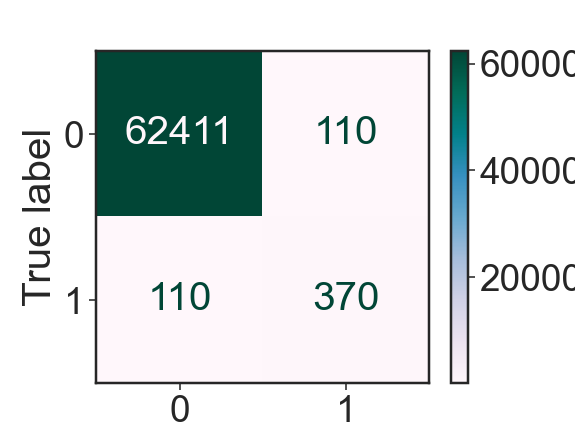

1
F1score: 0.7708333333333333
{0.1: {'AUC': 0.8845369622473517, 'Recall': 0.7708333333333334, 'AUCZ': 0.9614491421568627, 'F1': 0.7708333333333333, 'AUC_std': 0.0, 'Recall_std': 0.0, 'AUCZ_std': 0.0, 'F1_std': 0.0}}


In [26]:
result_dict = {}

for i in range(len(rho_values)):
    rho = rho_values[i]

    dataset = dataset0 + '_' + str(rho) 
    dir_in = infolder+net+'/injected/'

    file_load = True 

    NN = len(rseeds)
    precision_s = np.zeros(NN)
    recall_s    = np.zeros(NN)
    f1_s        = np.zeros(NN) 
    AUCZ_s      = np.zeros(NN)

    # initialize lists to store the performance metrics for each sample
    auc_scores = []
    accuracy_scores = []
    brier_scores = []
    f1_scores = []


    if not os.path.exists(dir_out1):
        os.makedirs(dir_out1) 
    rseed = rseeds[0]
    rng = np.random.RandomState(rseed)
    itr = 0
    while (itr < NN): 
        rseed = rseeds[itr]
        # G1 = nx.Graph(G[0]) 
        label = dataset 
        '==============================================================='
        network = dir_in + dataset+ '_' + str(rseed)+'_injected.dat'
        print('='*35)
        print('network:', network)
        '==============================================================='

        if file_load:
            #loading the anomalous edges 
            df_anomalous_edges = pd.read_csv(dir_in + dataset+ '_' + str(rseed)+'_anomalous_edges.dat', sep='\s+', header=None)  
            a_edgelist = df_anomalous_edges.values.astype(str)  

            #add the  anomalous edges to the graph 
            anomalous_edges = list(zip(a_edgelist[:,0], a_edgelist[:,1]))   
            unique_anomalous_edges = list(set(anomalous_edges)) 
            anomalous_edges = list(unique_anomalous_edges)
            print('='*100) 
            print('len(anomalous_edges):', len(anomalous_edges))

            #loading the gt for the injected anomaly 
            print('='*100) 
            print(dir_in + 'theta_gt_z_'+dataset+ '_' + str(rseed)+'.npz') 
            theta_gt_z = np.load(dir_in + 'theta_gt_z_'+dataset+ '_' + str(rseed)+'.npz',allow_pickle=True)

            A_at, B_at, B_T_at, data_T_vals_at = DynACD.tools.import_data(network,force_dense=True, undirected=False, binary=True, ego='source', alter='target', sep='\s+')#, B_T, data_T_vals
            nodes = A_at[0].nodes()
            pos = nx.spring_layout(A_at[0]) 
            N = len(nodes)

            L = B_at.shape[0] 
            mask_input = None

            t = B_at.shape[0] - 1

        print('='*100)
        print(dir_out1+'injected/theta_'+dataset+ '_' + str(rseed)+'_injected_8_True_ACD_Wdynamic.npz')
        theta_acd = np.load(dir_out1+'injected/theta_'+dataset+ '_' + str(rseed)+'_injected_8_True_ACD_Wdynamic.npz')
        u_an, v_an, w_an = theta_acd['u'],theta_acd['v'],theta_acd['w'] 
        pi_an,mu_an= theta_acd['pi'], theta_acd['mu']
        beta_an, phi_an, ell_an= theta_acd['beta'], theta_acd['phi'], theta_acd['ell']
        print('='*100)
        print('pi_an,mu_an,beta_an, phi_an, ell_an:', pi_an,mu_an,beta_an, phi_an, ell_an)

        M0_an  = DynACD.cv_functions._lambda0_full(u_an, v_an, w_an[1:])
        M00_an = DynACD.cv_functions._lambda0_full(u_an, v_an, (w_an[0])[np.newaxis,:]) 
        print('B_at.shape, t:', B_at.shape, t)

        Q_an = DynACD.cv_functions.QIJ_dense(B_at,(B_at[0])[np.newaxis,:,:],M0_an,(M00_an[-1])[np.newaxis,:,:],T= t, beta=beta_an, phi=phi_an, pi = pi_an, ell=ell_an, mu= mu_an)  
#         M_an = DynACD.cv_functions.calculate_conditional_expectation_Q(M0_an[-1], Q_an, beta=beta_an, phi=phi_an, ell=ell_an) # use data at time t-1 to predict t 

#         subs_nzp =  B_at[t].nonzero()
#         M_an[subs_nzp] = (1-Q_an)[subs_nzp] * (1 - beta_an) + Q_an[subs_nzp] * (1 - phi_an)# to calculate AUC
        B_aggr = B_at.sum(axis=0)

        mask_tmp = np.zeros(B_aggr.shape)
        mask_tmp[B_aggr > 0] = 1
        Q_inf = Q_an*mask_tmp 
        z_pred = np.zeros(B_aggr.shape)
        AUCZ_s[itr] = DynACD.cv_functions.calculate_AUC(Q_an, theta_gt_z['z'],mask=mask_tmp)
        print('='*65)
        print('AUCZ_s[itr]:', AUCZ_s[itr])
#         AUCZ_s[itr] = DynACD.cv_functions.calculate_AUC(Q_an, theta_gt_z['z'],mask=None)
#         AUCZ_s[itr] = DynACD.cv_functions.calculate_AUC(Q_an, theta_gt_z['z'],mask=(np.logical_not(mask_tmp)))

        idx_d = {}
        for idx, n in enumerate(A_at[0].nodes()): 
            idx_d[idx] = n

        anomaly_graph = nx.DiGraph()
        anomaly_graph.add_nodes_from(A_at[0].nodes())

        for layer_index, graph in enumerate(A_at): 
            anomaly_graph.add_edges_from(graph.edges(), layer=layer_index) 

        len_an = len(anomalous_edges) 

        all_edges_0 = list(anomaly_graph.edges()) 
        all_edges = list(set(all_edges_0))  

        labels = []
        for idx,eg in enumerate(all_edges):  
            idi,idj = [k for k, v in idx_d.items() if v == eg[0]][0],[k for k, v in idx_d.items() if v == eg[1]][0] 
            labels.append(Q_an[idi][idj]) 
        vals = dict(zip(all_edges, labels))   

        s_vals = dict(sorted(vals.items(), key=lambda item: item[1]))  
        s_vals = sorted(vals.items(), key=lambda x: x[1])
        max_vals = s_vals[-1*len_an:]  
        anomalous_edges_inf = [max_vals[i][0] for i in range(len(max_vals))]
        print(len(set(anomalous_edges).intersection(set(anomalous_edges_inf)))) 

        for eges in anomalous_edges_inf: 
            idx = [k for k, v in idx_d.items() if v == eges[0]][0]
            idy = [k for k, v in idx_d.items() if v == eges[1]][0] 
            z_pred[idx][idy] = 1
        print('='*65)
        cm = confusion_matrix(theta_gt_z['z'].flatten(), z_pred.flatten())
        disp = ConfusionMatrixDisplay(confusion_matrix=cm) 
        disp.plot(cmap=cmap)
        plt.show()
   
        auc_scores.append(roc_auc_score(      z_pred.flatten(),theta_gt_z['z'].flatten()))
        f1_scores.append(f1_score(            z_pred.flatten(),theta_gt_z['z'].flatten()))

        precision_s[itr] = metrics.precision_score(theta_gt_z['z'].flatten(), z_pred.flatten())
        recall_s[itr]   = metrics.recall_score(theta_gt_z['z'].flatten(), z_pred.flatten())
        f1_s[itr]      = metrics.f1_score(theta_gt_z['z'].flatten(), z_pred.flatten())

        itr += 1
        print(itr)
    F1score = np.mean(f1_scores)
    print('F1score:', F1score)
    auc, recall, AUCZ, F1score, auc_std, recall_std, aucz_std, F1score_std = np.mean(auc_scores), np.mean(precision_s), np.mean(AUCZ_s), np.mean(f1_scores), np.std(auc_scores), np.std(precision_s), np.std(AUCZ_s), np.std(f1_scores)
    rho_dict = {
        'AUC': auc,
        'Recall': recall,
        'AUCZ'  : AUCZ,
        'F1':F1score,
        'AUC_std': auc_std,
        'Recall_std': recall_std,
        'AUCZ_std': aucz_std,
        'F1_std':F1score_std,
    }

    result_dict[rho] = rho_dict


print(result_dict)


In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

# Your existing code
sns.set_style("white", {'axes.grid' : False})
sns.set_palette("tab10", 8, .75) 
sns.set_style('ticks') 
custom_params = {"axes.spines.right": True, "axes.spines.top": True, "lines.linewidth": 12}

# Increase the thickness of the axes
custom_params["axes.linewidth"] = 2.0  # You can adjust the value according to your preference

# Set the seaborn theme with modified parameters
sns.set_theme(style="ticks", rc=custom_params, font_scale=2.7, palette="tab10")

# Your plotting code here


In [40]:
import numpy as np


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True, dataset=dataset):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues') 

#     plt.figure(figsize=(6,6)) # figsize=(11,11)
    plt.figure(figsize=(11,11), dpi=350)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
#     plt.colorbar(fraction=0.042, pad=0.12)
#     plt.size_inches(10, 4) # for 1x2
#     plt.colorbar(cm,fraction=0.046, pad=0.04)

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=0)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


#     plt.tight_layout()
    plt.ylabel('True label',labelpad=0, fontsize="42")
    plt.xlabel('Predicted label',labelpad=0, fontsize="42")
    print('../figures/'+str(dataset)+'_HP_confusion_matrix_new')
#     plt.savefig('../../figures/'+str(dataset)+'_HP_confusion_matrix_new.png', facecolor='white', edgecolor='none', dpi=300) 
    plt.savefig('../../figures/Transfermarket-2008_2023_01_HP_confusion_matrix.png', facecolor='white', edgecolor='none', dpi=350) 

#     plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show() 

<IPython.core.display.Javascript object>


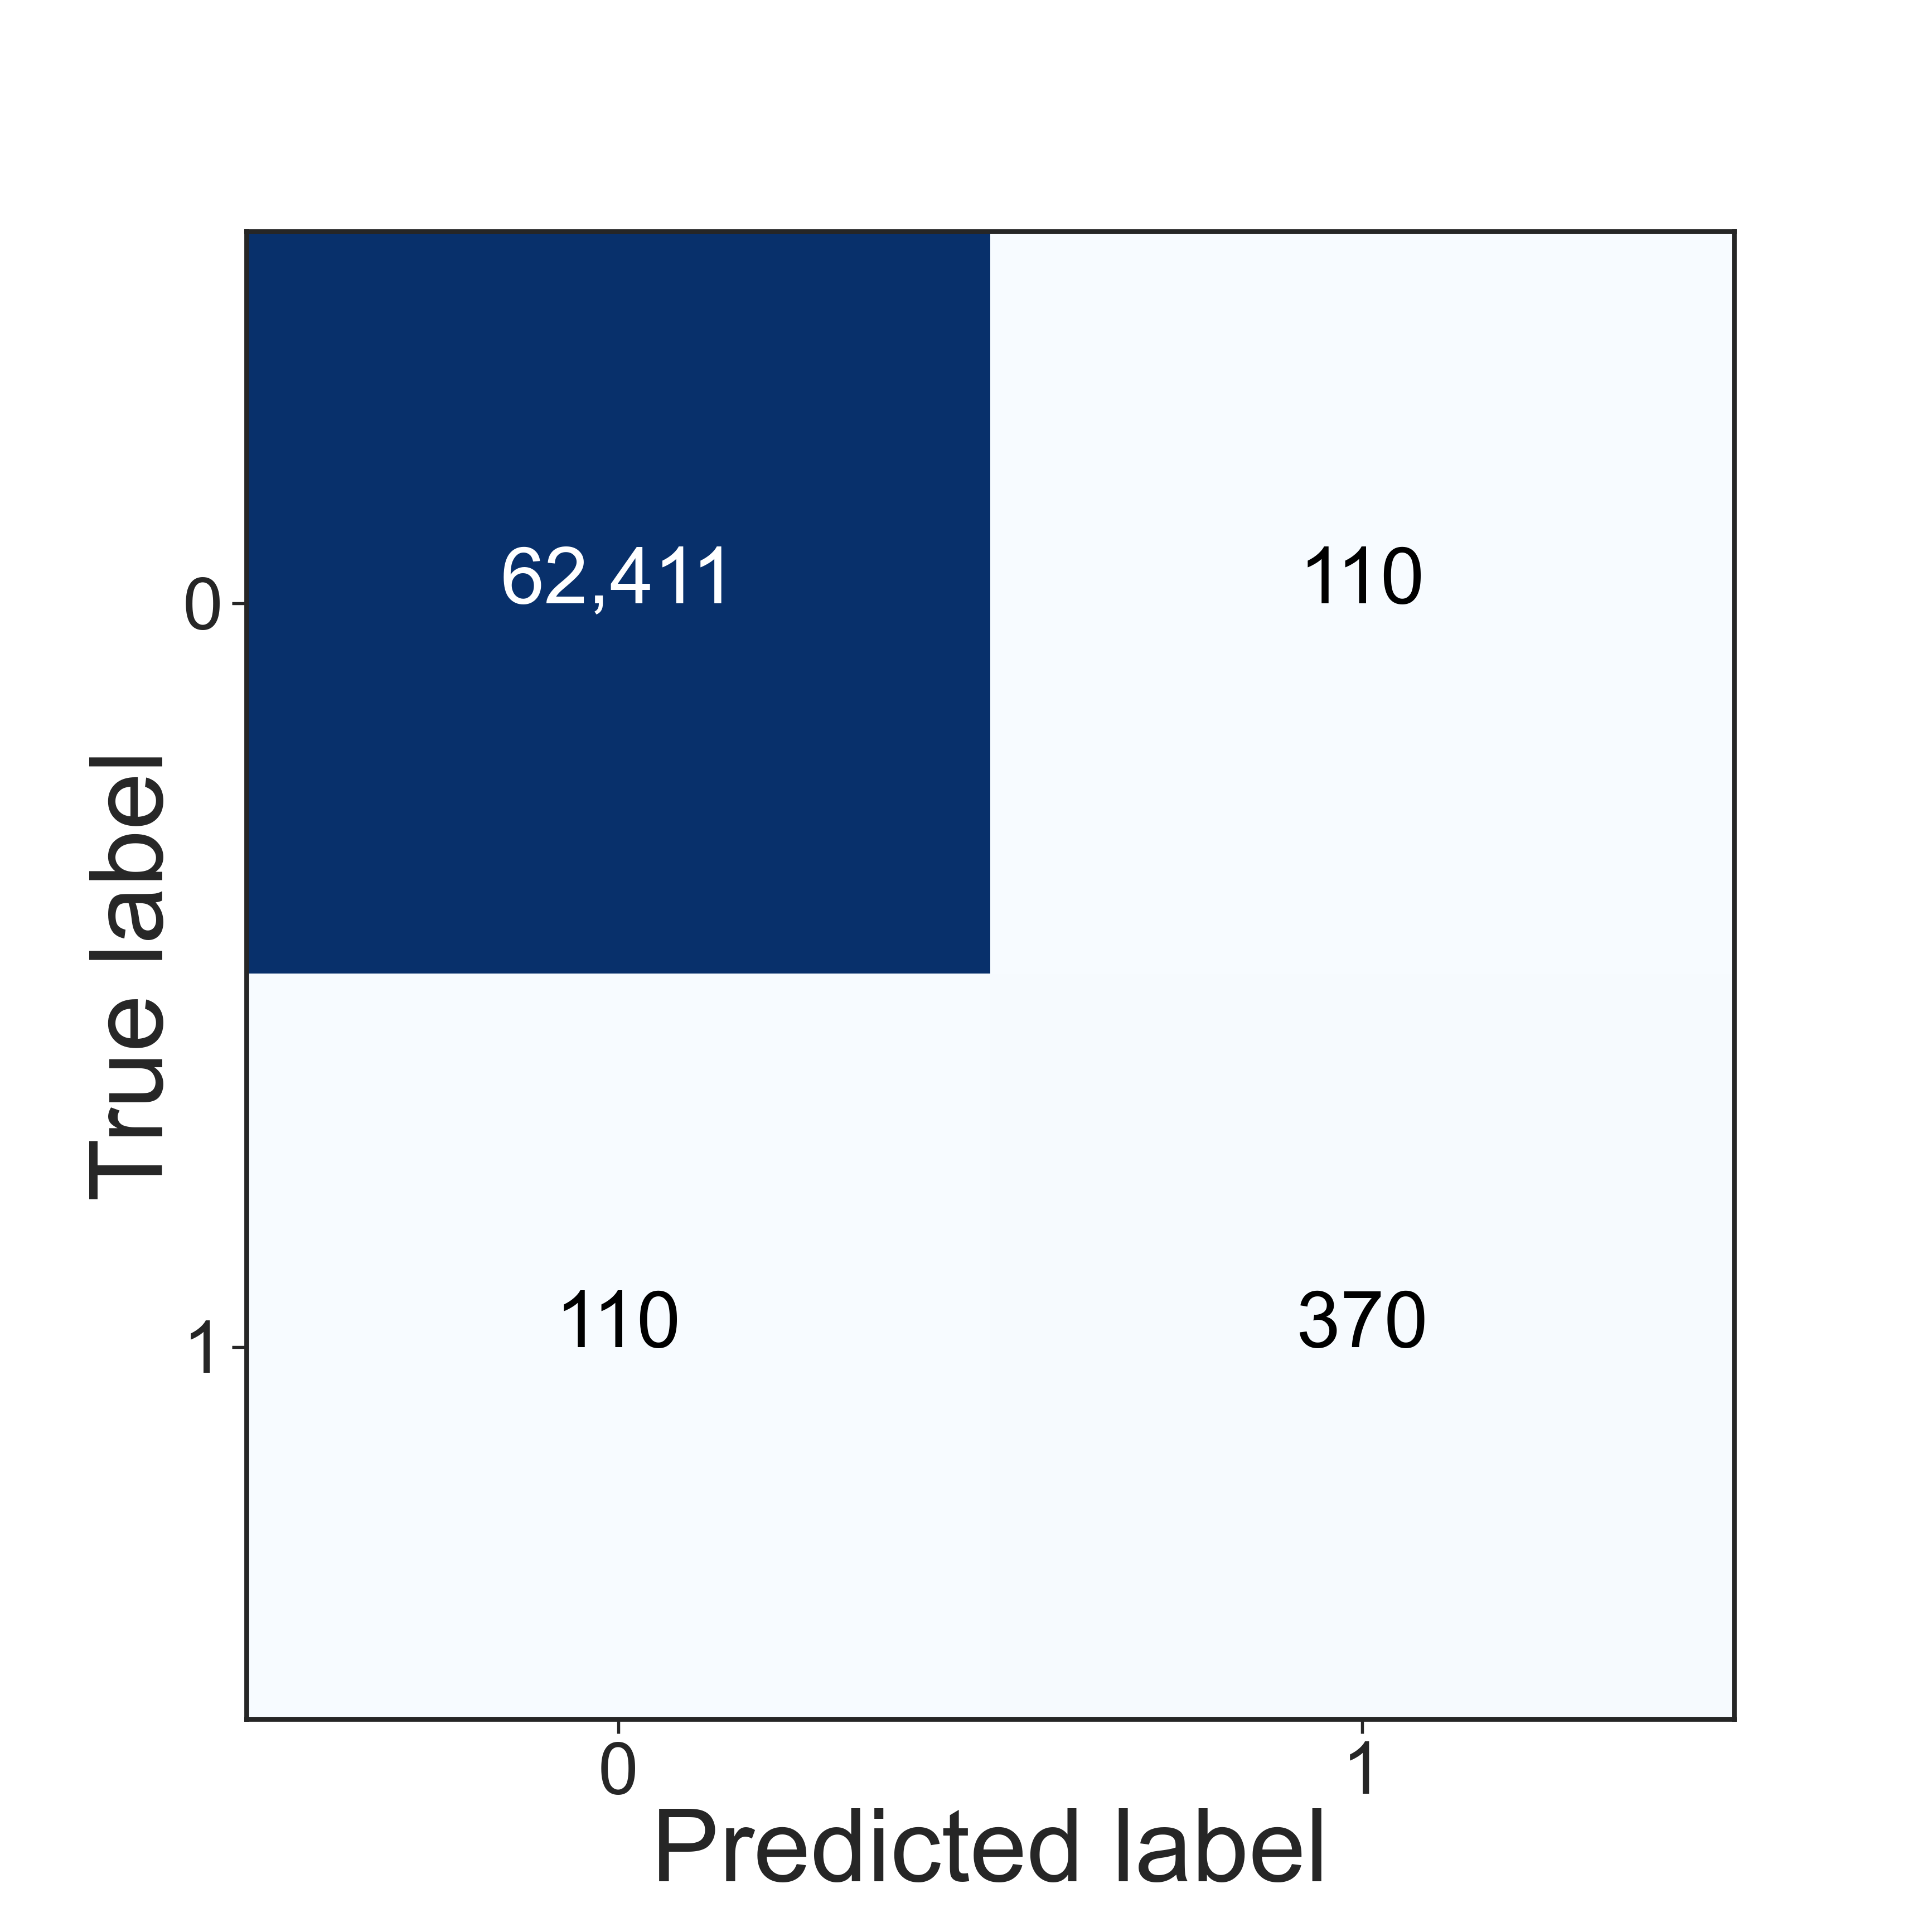

../figures/adjacency_2008_23_len_0.1_HP_confusion_matrix_new


In [41]:
plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = False,                # show proportions
                          target_names = [0,1],       # list of names of the classes
                          title        = None, dataset=dataset) # title of graph

In [42]:
# sns.set_palette("dark", 8, .75) 
import seaborn as sns
sns.set_context("talk", font_scale=2.8, rc={"lines.linewidth": 12} )  
# custom_params = {"axes.spines.right": False, "axes.spines.top": False}#style="ticks", 
sns.set_theme(font_scale=3., palette="tab10") 
sns.set_context("talk")# Option: "paper","notebook","talk","poster",the later the bigger.
# sns.set_style('ticks') 
sns.set_style("white", {'axes.grid' : False})

In [43]:
def set_size(w,h, ax=None):
    """ w, h: width, height in inches """
    if not ax: ax=plt.gca()
    l = ax.figure.subplotpars.left
    r = ax.figure.subplotpars.right
    t = ax.figure.subplotpars.top
    b = ax.figure.subplotpars.bottom
    figw = float(w)/(r-l)
    figh = float(h)/(t-b)
    ax.figure.set_size_inches(figw, figh)

In [44]:
labels1 = []
for idx,eg in enumerate(all_edges):  
    idi,idj = [k for k, v in idx_d.items() if v == eg[0]][0],[k for k, v in idx_d.items() if v == eg[1]][0]
    labels1.append(Q_inf[idi][idj]) 
# # attr = 'Q'
# edges = list(Gn.edges())
# vals = dict(zip(edges, labels)) 
len(labels1)

5276

In [45]:
Q_lab     = ['Anomalous' if edgs in anomalous_edges_inf else 'Regular' for edgs in list(all_edges)]
theta_lab = ['Anomalous' if (edg_an in anomalous_edges) else 'Regular' for edg_an in  all_edges]

df_dict = {}
# df_dict = {'edg':[],'theta':[], 'Q':[], 'inferred':[], 'True Label':[]}  
df_dict['edg']   = [edgs for idx,edgs in  enumerate(all_edges)] 

# df_dict['theta'] = [np.maximum(nd_rels[i],nd_rels[j]) for i,j in A_at[0].edges()] 

# df_dict['Q']  = [Q_max[i,j] for i,j in A_at[0].edges()] 
df_dict['Q']  = labels1

df_dict['Inferred'] = Q_lab 
df_dict['True Label'] = theta_lab
print(len(df_dict['edg']), len(Q_lab))

5276 5276


In [46]:
reliabilities_df = pd.DataFrame()
reliabilities_df = pd.DataFrame(df_dict)
reliabilities_df.head(n=5)

,edg,Q,Inferred,True Label
0,"(Parma, Cagliari_Calcio)",4.275323e-03,Regular,Regular
1,"(SC_Lyon, Southampton)",2.127338e-02,Regular,Regular
2,"(Brighton, Suderland)",5.621454e-16,Regular,Regular
3,"(E._Frankfurt, Werder_Bremen)",4.659284e-03,Regular,Regular
4,"(FC_Köln, Werder_Bremen)",1.499704e-10,Regular,Regular


In [47]:
import seaborn as sns
import matplotlib.pyplot as plt

# Your existing code
sns.set_style("white", {'axes.grid' : False})
sns.set_palette("tab10", 8, .75) 
sns.set_style('ticks') 
custom_params = {"axes.spines.right": False, "axes.spines.top": False, "lines.linewidth": 2}

# Increase the thickness of the axes
custom_params["axes.linewidth"] = 2.0  # You can adjust the value according to your preference

# Set the seaborn theme with modified parameters
sns.set_theme(style="ticks", rc=custom_params, font_scale=3, palette="tab10")

# Your plotting code here


<IPython.core.display.Javascript object>


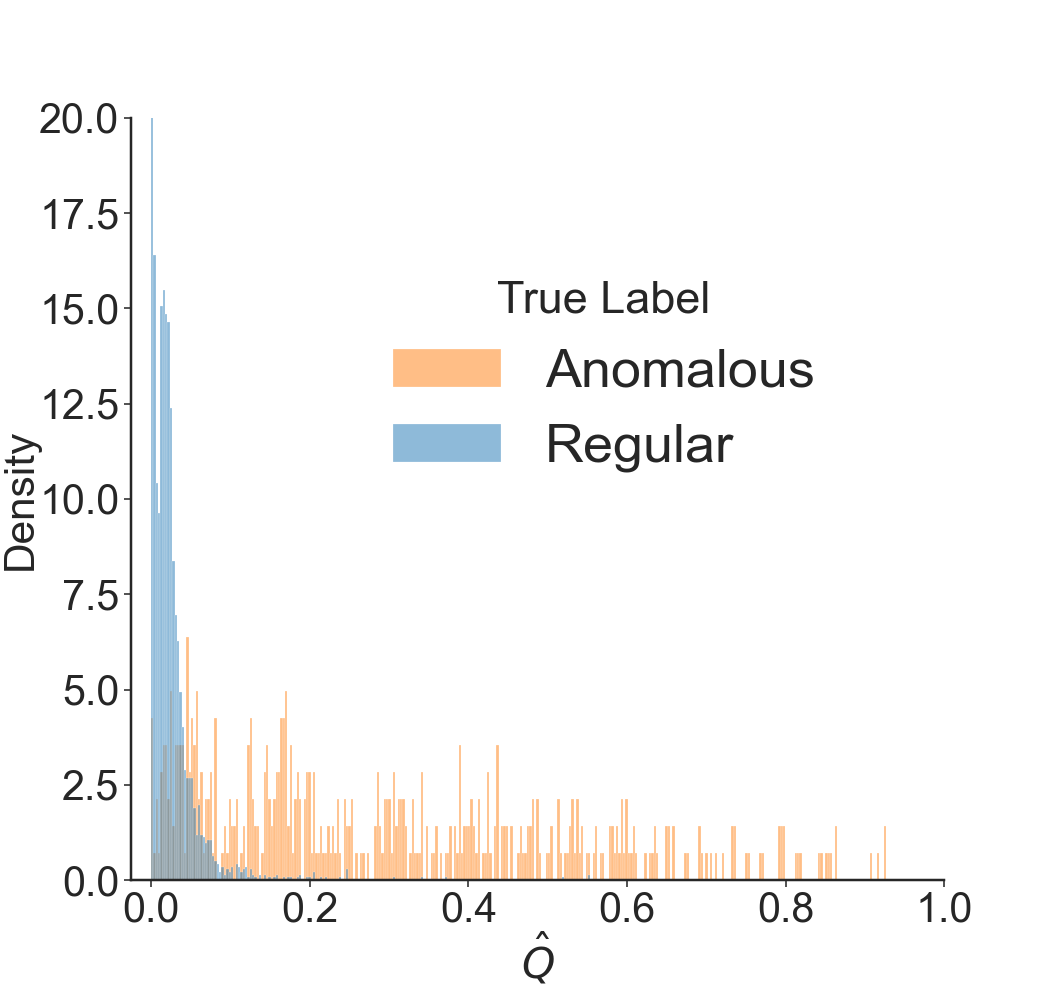

Text(0.5, 0, '$\\hat{Q}$')

In [48]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[11, 11]) 
# fig, ax = plt.subplots(nrows=1, ncols=1) 



# sns.displot(reliabilities_df, x="Q", hue="True Label", kind="kde", multiple="stack")
# g_dq = sns.displot(reliabilities_df, x="Q", hue="True Label", kind="kde", fill=True, common_norm=False)
g_dq = sns.histplot(reliabilities_df, x="Q", hue="True Label",stat="density", common_norm=False)
# g_dq = sns.histplot(reliabilities_df, x="Q", hue="True Label", multiple="stack", common_norm=False, kde=False)
# g_dq.legend.remove()
# g_dq.add_legend(title='True Label',label_order=["Regular","Anomalous"],frameon=False, bbox_to_anchor=(0.75, 0.8)) #loc='upper left' 
plt.legend(labels=["Anomalous","Regular"], title = "True Label",frameon=False
           , bbox_to_anchor=(0.9, 0.85), 
           fontsize = 'large', title_fontsize = "36")
ax.set_ylim([0, 20])
ax.set_xlim([-0.025, 1])
ax.set_ylabel('Density',labelpad=-0.5, fontsize="34")
ax.set_xlabel(r'$\hat{Q}$',labelpad=-0.1, fontsize="34")


In [50]:
fig.savefig('../../figures/Transfermarket-2008_2023_histplot.png', dpi=350)



